In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [3]:
# Define the ResNet150 model
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = BatchNormalization(axis=bn_axis, name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = Conv2D(filters, 1, strides=stride, name=name + '_1_conv')(x)
    x = BatchNormalization(axis=bn_axis, name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_relu')(x)

    x = Conv2D(filters, kernel_size, padding='same', name=name + '_2_conv')(x)
    x = BatchNormalization(axis=bn_axis, name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_relu')(x)

    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = BatchNormalization(axis=bn_axis, name=name + '_3_bn')(x)

    x = Add(name=name + '_add')([shortcut, x])
    x = Activation('relu', name=name + '_out')(x)
    return x


In [4]:
def stack_blocks(x, filters, blocks, stride1=2, name=None):
    x = residual_block(x, filters, stride=stride1, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = residual_block(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
    return x

In [5]:
def ResNet150(input_shape=(224, 224, 3)):
    img_input = Input(shape=input_shape)

    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    x = Conv2D(64, 7, strides=2, padding='same', name='conv1_conv')(img_input)
    x = BatchNormalization(axis=bn_axis, name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same', name='pool1_pool')(x)

    x = stack_blocks(x, 64, 3, stride1=1, name='conv2')
    x = stack_blocks(x, 128, 8, name='conv3')
    x = stack_blocks(x, 256, 36, name='conv4')
    x = stack_blocks(x, 512, 3, name='conv5')
    # Add custom layers on top of ResNet150 backbone
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(img_input, x, name='resnet150')
    return model


In [6]:
train_data_dir = 'training'
test_data_dir = 'validation'
# Define batch size and number of epochs
batch_size = 32
epochs = 150
input_shape = (224, 224)  # Assuming images are resized to 224x224


print(f"Batch size: {batch_size}")


Batch size: 32


In [7]:
# Load the ResNet150 model
model = ResNet150(input_shape=(224, 224, 3))

In [94]:
# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False



In [14]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "resnet150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 256)       │           1,024 │ conv2_block1_0_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_bn             │ (None, 56, 56, 256)       │           1,02

 Total params: 58,372,993 (222.68 MB)

 Trainable params: 58,221,569 (222.10 MB)

 Non-trainable params: 151,424 (591.50 KB)

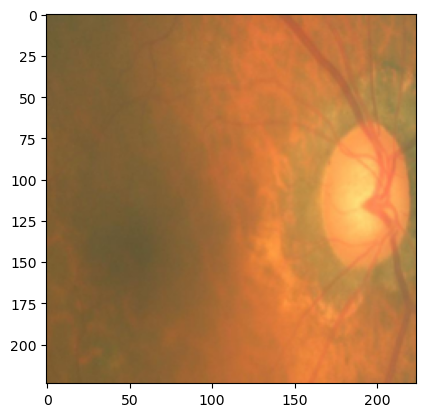

In [208]:
import cv2
from PIL import Image
import random
import os
import scipy.ndimage# Choose a random image from the training directory

class_names = os.listdir(train_data_dir)
chosen_class = random.choice(class_names)
class_dir = os.path.join(train_data_dir, chosen_class)
images = os.listdir(class_dir)
chosen_image = random.choice(images)
image_path = os.path.join(class_dir, chosen_image)

# Preprocess the image
img = cv2.imread(image_path, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img, 'RGB')
img = img.resize((224, 224))
img = np.array(img)
plt.imshow(img)
plt.show()




In [210]:
from tensorflow.keras.applications.resnet import preprocess_input
img_tensor = np.expand_dims(img, axis=0)
preprocessed_img = preprocess_input(img_tensor)
print(preprocessed_img.shape)

(1, 224, 224, 3)


In [212]:
last_layer_weights = model.layers[-1].get_weights()[0]  #Predictions layer


#Output both predictions (last layer) and conv5_block3_add (just before final activation layer)
ResNet_model = Model(inputs=model.input, 
        outputs=(model.layers[-4].output, model.layers[-1].output)) 
last_conv_output, pred_vec = ResNet_model.predict(preprocessed_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


In [213]:
last_conv_output = np.squeeze(last_conv_output) #7x7x2048
#Prediction for the image
pred = np.argmax(pred_vec)

# spline interpolation to resize each filtered image to size of original image 
h = int(img.shape[0]/last_conv_output.shape[0])
w = int(img.shape[1]/last_conv_output.shape[1])
upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1) # dim: 224 x 224 x 2048

print(last_conv_output.shape)
print(pred_vec.shape)


(7, 7, 2048)
(1, 1)


In [214]:
last_layer_weights_for_pred = last_layer_weights[:, pred] # dim: (2048,) 

#To generate the final heat map. 
#Reshape the upsampled last conv. output to n x filters and multiply (dot product) 
# with the last layer weigths for the prediction. 
# Reshape back to the image size for easy overlay onto the original image. 
heat_map = np.dot(upsampled_last_conv_output.reshape((224*224, 2048)), 
                  last_layer_weights_for_pred).reshape(224,224) # dim: 224 x 224
print(last_layer_weights_for_pred.shape)
print(heat_map.shape)

(2048,)
(224, 224)


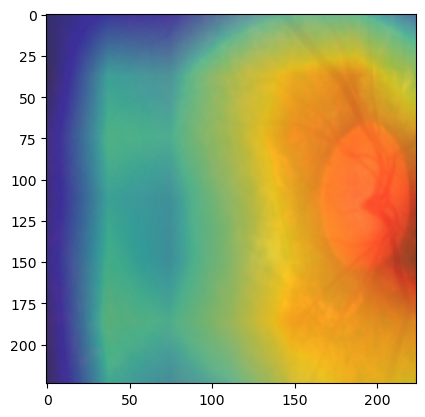

In [215]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.imshow(heat_map, cmap='jet', alpha=0.5)

plt.show()